# Analyzing CommonVoice data with Pandas
Python for Data Science

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install mosestokenizer
!pip install stop-words
!pip install punctuation-remove

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for mosestokenizer: filename=mosestokenizer-1.2.1-py3-none-any.whl size=49171 sha256=9b15718978fb821c7a02fb65bf190b59791d5aa1c7e6dd95790ac85a789871f5
  Stored in directory: /root/.cache/pip/wheels/80/d8/15/4c5ebbe883513f003cb055a0369c77c9df857023a706f39e70
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7501faa8fe1f61be2f5f099be6c112223a3081ff1b32d6ea1a22d36d627d9adf
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for toolwrapper: filename=toolwrapper-2.1.0-py3-none-any.whl size=3337 sha256=059155a37c2930016f2383185bf3c1d7fb7c62d9489e44943d36219d28822fc1
  Stored in directory: /root/.cache/pip/wheels/e1/af/b1/99b57a06dda78fdcee86d2e22c64743f3b8df8f31cfc04baf7
  Created wheel for uctools: filenam

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
from mosestokenizer import MosesTokenizer
from collections import Counter
from stop_words import get_stop_words, safe_get_stop_words
from punctuation import Punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## 1 Analyzing CommonVoice
The aim is to analyze the CommonVoice corpus and build test and train sets with certain characteristics.

1. For each language, determine the total duration of recording and the number of different
speakers.

In [ ]:
#!tar -xvf "/content/drive/MyDrive/Data analysis/data/metadata.tar.bz2" -C "/content/drive/MyDrive/Data analysis/data"
all_recordings = pd.concat([pd.read_csv(path, delimiter='\t') for path in Path("/content/drive/MyDrive/Data_analysis/data/metadata").rglob("*.tsv") if path.stem in {"train", "test"}])
list(Path("metadata").rglob("clip_durations.tsv"))
all_durations = pd.concat([pd.read_csv(path, delimiter='\t') for path in Path("/content/drive/MyDrive/Data_analysis/data/metadata").rglob("clip_durations.tsv")])
df_all = pd.merge(all_recordings, all_durations, left_on="path", right_on="clip", validate="1:1")

<ipython-input-4-a91900e0c368>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_recordings = pd.concat([pd.read_csv(path, delimiter='\t') for path in Path("/content/drive/MyDrive/Data_analysis/data/metadata").rglob("*.tsv") if path.stem in {"train", "test"}])


In [ ]:
df_all.rename(columns={'locale': 'language'}, inplace=True)
df_all

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,language,segment,clip,duration[ms]
0,0237f666c0b4f0779056b7c9289e40c170c6b0974b4214...,common_voice_ar_28865270.mp3,زارني في أوائل الشهر بدري,2,0,twenties,male,NaN,NaN,ar,NaN,common_voice_ar_28865270.mp3,4320
1,053a91dfd8c87629424edbb1a98cebea127137e6532174...,common_voice_ar_22931432.mp3,من الممكن أنها لن تأتي غداً.,2,0,NaN,NaN,NaN,NaN,ar,NaN,common_voice_ar_22931432.mp3,3936
2,073c6a4a1887384a1d6145a3258b7ca48de9f441c1762f...,common_voice_ar_26338992.mp3,إبنك بطل.,2,0,NaN,NaN,NaN,NaN,ar,NaN,common_voice_ar_26338992.mp3,3744
3,08ea1e4883b0112f794e6cba73552d702ba257721b88df...,common_voice_ar_35782277.mp3,جاء ذلك الغبيّ يبحث عنّي.,2,0,NaN,NaN,NaN,NaN,ar,NaN,common_voice_ar_35782277.mp3,4788
4,0aab971eac3eabea7027b19bedcde9f9bf1162f536326d...,common_voice_ar_25175528.mp3,الواعظ الأمرد هذا الذي,2,0,NaN,NaN,NaN,NaN,ar,NaN,common_voice_ar_25175528.mp3,3636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087044,b85e0c9ae3d43b73fa66b1bff0f042a0498a6210f9bc87...,common_voice_ta_34508575.mp3,நகருதே என்னுடன் என்வீடு!,2,0,NaN,NaN,NaN,NaN,ta,NaN,common_voice_ta_34508575.mp3,4680
3087045,b85e0c9ae3d43b73fa66b1bff0f042a0498a6210f9bc87...,common_voice_ta_34514514.mp3,தேவர்களின் கயமைத் தனத்தை எதிர்த்தே அசுரர்கள் ப...,2,0,NaN,NaN,NaN,NaN,ta,NaN,common_voice_ta_34514514.mp3,5760
3087046,b85e0c9ae3d43b73fa66b1bff0f042a0498a6210f9bc87...,common_voice_ta_34515372.mp3,"மின்னோட்டம், மின்தடை, மின்னழுத்தம் முதலியவற்றை...",2,0,NaN,NaN,NaN,NaN,ta,NaN,common_voice_ta_34515372.mp3,7020
3087047,b85e0c9ae3d43b73fa66b1bff0f042a0498a6210f9bc87...,common_voice_ta_34907643.mp3,வாழ்க்கையை மறுக்கும் அணியினர் பேச்சை அன்புகூர்...,2,0,NaN,NaN,NaN,NaN,ta,NaN,common_voice_ta_34907643.mp3,6336


In [ ]:
df_all.keys()

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accents', 'variant', 'language', 'segment', 'clip',
       'duration[ms]'],
      dtype='object')

In [ ]:
# Calculate total duration and unique speakers for each language
summary_df = (df_all.groupby('language')
                  .agg({'duration[ms]': 'sum', 'client_id': 'nunique'})
                  .reset_index()
                  .rename(columns={'duration[ms]': 'Total Duration (ms)', 'client_id': 'Number of Unique Speakers'}))

summary_df

,language,Total Duration (ms),Number of Unique Speakers
0,ar,162160035,982
1,de,3341755685,12277
2,en,6174878911,47861
3,es,1720018728,10990
4,fr,2820768179,12153
5,id,42566295,332
6,it,975913433,5098
7,ja,57698436,1073
8,lg,466082146,514
9,ru,192763014,2144


2. For each language and each gender determine the total duration of recordings, the number of different speakers, the average, median, min and max number of recordings per speaker.

In [ ]:
# Save the undetermined genders in a DataFrame
undetermined_df = df_all[df_all['gender'].isna()].copy()
undetermined_df['gender'] = 'undetermined'

# Concatenate it with the original DataFrame
df_combined = pd.concat([df_all, undetermined_df], ignore_index=True)

# Group and aggregate the combined DataFrame
stat_df = (df_combined.groupby(['language', 'gender'])
    .agg({'duration[ms]': 'sum', 'client_id': 'nunique'})
    .join(df_combined.groupby(['language', 'gender', 'client_id']).size()
    .groupby(['language', 'gender'])
    .agg(['mean', 'median', 'min', 'max'])
    .add_prefix('Recordings per Speaker '))
    .reset_index()
    .rename(columns={'duration[ms]': 'Total Duration (ms)', 'client_id': 'Number of Unique Speakers'}))
stat_df

,language,gender,Total Duration (ms),Number of Unique Speakers,Recordings per Speaker mean,Recordings per Speaker median,Recordings per Speaker min,Recordings per Speaker max
0,ar,female,26649792,87,71.988506,17.0,1,1286
1,ar,male,35590808,301,27.312292,8.0,1,1174
2,ar,other,149616,8,4.875000,3.0,1,19
3,ar,undetermined,99769819,671,36.299553,4.0,1,2517
4,de,female,256048399,576,77.555556,18.0,1,3068
5,de,male,1857171870,3111,104.833815,15.0,1,60854
6,de,other,24376606,50,94.620000,14.5,1,2731
7,de,undetermined,1204158810,9069,23.003529,5.0,1,23248
8,en,female,1211778903,3177,66.204910,11.0,1,9795
9,en,male,2965272609,11394,46.338336,8.0,1,47480


In [ ]:
stat_df = (df_all.groupby(['language', 'gender'])
                   .agg({'duration[ms]': 'sum', 'client_id': 'nunique'})
                   .join(df_all.groupby(['language', 'gender', 'client_id']).size()
                   .groupby(['language', 'gender'])
                   .agg(['mean', 'median', 'min', 'max'])
                   .add_prefix('Recordings per Speaker '))
                   .reset_index()
                   .rename(columns={'duration[ms]': 'Total Duration (ms)', 'client_id': 'Number of Unique Speakers'}))

stat_df

,language,gender,Total Duration (ms),Number of Unique Speakers,Recordings per Speaker mean,Recordings per Speaker median,Recordings per Speaker min,Recordings per Speaker max
0,ar,female,26649792,87,71.988506,17.0,1,1286
1,ar,male,35590808,301,27.312292,8.0,1,1174
2,ar,other,149616,8,4.875000,3.0,1,19
3,de,female,256048399,576,77.555556,18.0,1,3068
4,de,male,1857171870,3111,104.833815,15.0,1,60854
5,de,other,24376606,50,94.620000,14.5,1,2731
6,en,female,1211778903,3177,66.204910,11.0,1,9795
7,en,male,2965272609,11394,46.338336,8.0,1,47480
8,en,other,131645246,330,73.615152,14.0,1,8137
9,es,female,474956697,1095,84.236530,12.0,1,20353


3. Which language has the highest proportion of recordings by a person in the largest age bracket considered ?
= the one containing the oldest people

In [ ]:
result = (df_all.groupby(['language', 'client_id', 'age'])['path']
           .count()
           .groupby(['language', 'age'])
           .transform('max')
           .reset_index()
           .rename(columns={'path': 'Proportion'})
           .sort_values(by='Proportion', ascending=False)
           .head(1))

result[['language', 'age', 'Proportion']]

,language,age,Proportion
1051,de,fourties,41852


In [ ]:
df_all["age"].unique()

array(['twenties', nan, 'fourties', 'teens', 'thirties', 'sixties',
       'fifties', 'nineties', 'seventies', 'eighties'], dtype=object)

In [ ]:
# Define a mapping of age categories to numerical values
age_mapping = {'teens': 10,'twenties': 20,'thirties': 30,'fourties': 40,
               'fifties': 50,'sixties': 60,'seventies': 70,
               'eighties': 80,'nineties': 90
}

# Map the age categories to numerical values
df_all['age_numerical'] = df_all['age'].map(age_mapping)

# Group the data by 'language' and find the maximum age within each language
oldest_speakers = df_all.groupby('language')['age_numerical'].max().reset_index()
oldest_speakers

,language,oldest_age
0,ar,90.0
1,de,90.0
2,en,90.0
3,es,90.0
4,fr,80.0
5,id,50.0
6,it,90.0
7,ja,90.0
8,lg,90.0
9,ru,60.0


In [ ]:
# Define a mapping of age categories to numerical values
age_mapping = {'teens': 10,'twenties': 20,'thirties': 30,'fourties': 40,
               'fifties': 50,'sixties': 60,'seventies': 70,
               'eighties': 80,'nineties': 90
}

# Map the age categories to numerical values
df_all['age_numeric'] = df_all['age'].map(age_mapping)
# Group the data by language and find the maximum age within each language
oldest_speakers = df_all.groupby('language')['age_numeric'].max().reset_index()
oldest_speakers = oldest_speakers.rename(columns={'age_numeric': 'oldest_age'})

# Filter the original DataFrame to include only the oldest age group for each language
filtered_df = df_all[df_all['language'].isin(oldest_speakers['language'])]
filtered_df = filtered_df[filtered_df['age_numeric'] == filtered_df.groupby('language')['age_numeric'].transform(max)]

# Group the filtered data by language, speaker, and age to count the number of entries
result = (filtered_df.groupby(['language', 'client_id', 'age'])['path']
           .count()
           .reset_index()
           .rename(columns={'path': 'Number of Recordings'})
           .sort_values(by='Number of Recordings', ascending=False)
           .head(1))

result[['language', 'age', 'client_id', 'Number of Recordings']]

,language,age,client_id,Number of Recordings
18,lg,nineties,cb684886da071f9271fa154a6228cb11474bdceab3ecdf...,352


4. Determine the number of different genders considered in the corpus. What is the percentage of recordings for which no gender information is available ? Plot the genre distribution (including cases where gender information is not available). Do the same for ages.

In [ ]:
df_all[df_all['gender'] =='other']

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,language,segment,clip,duration[ms]
36,30c7fc5a331d1dcfa95175b4c686e84f742e9ef768cf70...,common_voice_ar_19235572.mp3,تقوم أمي بإعداد كعكة لأجل أبي.,2,1,twenties,other,NaN,NaN,ar,NaN,common_voice_ar_19235572.mp3,5856
209,41bd311fae249fa6828bdf0598acd6b5f676e02c452c80...,common_voice_ar_20933525.mp3,.ها هو العنوان,2,0,thirties,other,NaN,NaN,ar,NaN,common_voice_ar_20933525.mp3,3576
210,41bd311fae249fa6828bdf0598acd6b5f676e02c452c80...,common_voice_ar_20933534.mp3,لا يمكنك الحضور ؟ لمَ لا ؟,2,0,thirties,other,NaN,NaN,ar,NaN,common_voice_ar_20933534.mp3,4416
317,e52f33307a847342e87d7282eb316ca2bd798de1972157...,common_voice_ar_25518694.mp3,ما رأيكم؟,2,1,teens,other,NaN,NaN,ar,NaN,common_voice_ar_25518694.mp3,2628
318,e52f33307a847342e87d7282eb316ca2bd798de1972157...,common_voice_ar_25518699.mp3,أظن أن توم لطيف.,2,0,teens,other,NaN,NaN,ar,NaN,common_voice_ar_25518699.mp3,3996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653136,923d18708f2b76a24c4e5e835d208c5d4f45a33af40c7f...,common_voice_fr_31817172.mp3,"Il joua un jazz innovant proche du cool jazz, ...",2,0,twenties,other,Français de France,NaN,fr,NaN,common_voice_fr_31817172.mp3,6300
2653137,923d18708f2b76a24c4e5e835d208c5d4f45a33af40c7f...,common_voice_fr_31817173.mp3,Olive Church of God ayant eu lieu le s'ouvre à...,2,0,twenties,other,Français de France,NaN,fr,NaN,common_voice_fr_31817173.mp3,5976
2653138,923d18708f2b76a24c4e5e835d208c5d4f45a33af40c7f...,common_voice_fr_31817174.mp3,Le voltigeur Scott Hairston signe chez les Cub...,2,0,twenties,other,Français de France,NaN,fr,NaN,common_voice_fr_31817174.mp3,4608
2653139,923d18708f2b76a24c4e5e835d208c5d4f45a33af40c7f...,common_voice_fr_31817175.mp3,La direction artistique est confiée à André An...,2,0,twenties,other,Français de France,NaN,fr,NaN,common_voice_fr_31817175.mp3,6300


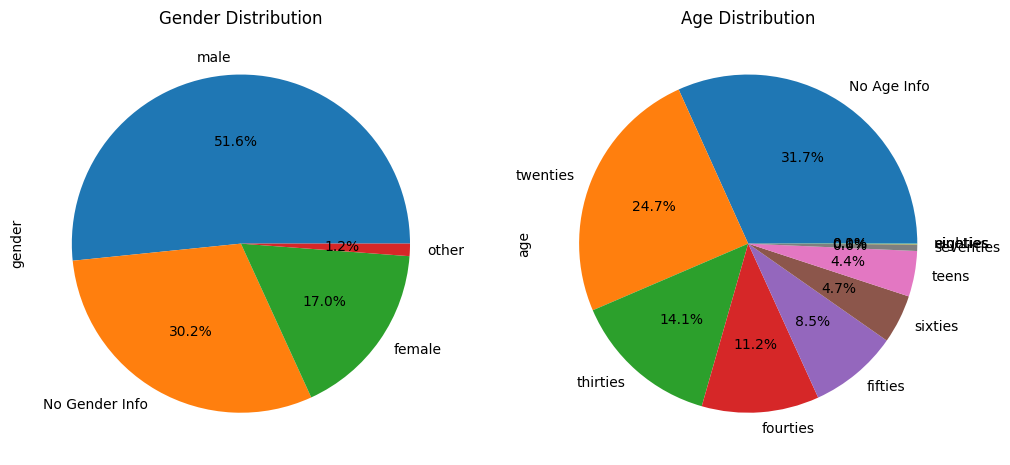

In [ ]:
num_unique_genders = df_all['gender'].nunique()
percentage_no_gender_info = (df_all['gender'].isna().mean() * 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Plot the gender distribution
df_all['gender'].fillna('No Gender Info').value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('Gender Distribution')

# Plot the age distribution
df_all['age'].fillna('No Age Info').value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Age Distribution')
plt.show()

print(f'Number of Different Genders: {num_unique_genders}')
print(f'Percentage of Recordings with No Gender Information: {percentage_no_gender_info:.2f}%')

5. Find out for each language and each gender the 7 speakers who produced the most recordings.

In [ ]:
top_speakers = df_all.groupby(['language', 'gender', 'client_id'])['path'] \
                     .count() \
                     .reset_index() \
                     .groupby(['language', 'gender'], group_keys=False) \
                     .apply(lambda x: x.nlargest(7, 'path'))
top_speakers

,language,gender,client_id,path
38,ar,female,78c954e30fd3a81e4abc72008b6c25427f6cb545275c59...,1286
30,ar,female,5f810213ca8e05e0d27a618d7a9e06c8ce4a2f4ca21eab...,1019
85,ar,female,fc3b87e39142b5fced5eb2422f0f5277bdf471c8865e9a...,526
66,ar,female,d7517b67ab736aa3e93a6ff78544e9f6e5be2540651522...,492
61,ar,female,c8a5a7e7ec79a0962b671878dc7de66774a4c7c58afb3a...,399
...,...,...,...,...
32117,zh-CN,other,8a2fc21b44d2c005616923c7997aac35e2d19e640b806c...,7
32120,zh-CN,other,b06ee136b9ab85349742e4bdb3d976d49ec971b37e0389...,4
32118,zh-CN,other,9bdbe9c49cc619513057e43ecb888570c176b6027fcf03...,3
32113,zh-CN,other,344489e9898b3cd9c5d29005768c95d2258e280dd9cff6...,1


6. For each language, create a 1-hour test set and a training set as large as possible, ensuring that speakers from the test set do not appear in the training set.

In [ ]:
# Sort the DataFrame by language and duration in descending order
df_all = df_all.sort_values(by=['language', 'duration[ms]'], ascending=[True, False])
test_set, training_set = pd.DataFrame(), pd.DataFrame()
test_set_durations = {}

# Populate test and training sets
for _, row in df_all.iterrows():
    lang, dur = row['language'], row['duration[ms]']
    test_set_durations[lang] = test_set_durations.get(lang, 0) + dur
    target_set = test_set if test_set_durations[lang] <= 3600000 else training_set # 1 hour in milliseconds
    target_set = pd.concat([target_set, row.to_frame().T], ignore_index=True)

# Ensure that the training set does not contain speakers from the test set
training_set = training_set[~training_set['client_id'].isin(test_set['client_id'])]

# Print the shapes (sizes) of the test and training sets
print("Test Set Shape:", test_set.shape)
print("Training Set Shape:", training_set.shape)

7. How many languages have more female than male recordings ?

In [ ]:
# Group the DataFrame by language and gender and count the recordings in each group
gender_counts = df_all.groupby(['language', 'gender'])['path'].count().unstack(fill_value=0)

# Check for languages where the female count is greater than the male count
languages_with_more_females = gender_counts[gender_counts['female'] > gender_counts['male']]

# Count the number of such languages
num_languages_with_more_females = len(languages_with_more_females)
print("Number of languages with more female recordings:", num_languages_with_more_females)
print("Languages with more female recordings:", languages_with_more_females.index.tolist())

Number of languages with more female recordings: 3
Languages with more female recordings: ['lg', 'sw', 'ta']


8. Which language has the most unbalanced gender distribution ?

In [ ]:
# Group the DataFrame by language and gender and count the recordings in each group
gender_counts = df_all.groupby(['language', 'gender'])['path'].count().unstack(fill_value=0)

# Calculate the absolute difference between female and male counts for each language
gender_counts['gender_difference'] = abs(gender_counts['female'] - gender_counts['male'])

# Find the language with the highest gender difference
most_unbalanced_language = gender_counts['gender_difference'].idxmax()

# Get the value of the highest gender difference
highest_gender_difference = gender_counts['gender_difference'].max()

# Print the result
print(f"Language with the most unbalanced gender distribution: {most_unbalanced_language}")
print(f"Highest gender difference: {highest_gender_difference}")

Language with the most unbalanced gender distribution: en
Highest gender difference: 317646


In [ ]:
# Find the language with the most unbalanced gender distribution
most_unbalanced_language = df_all.groupby(['language', 'gender'])['path'].count().unstack(fill_value=0).eval('abs(female - male)').idxmax()

# Get the value of the highest gender difference
highest_gender_difference = df_all.groupby(['language', 'gender'])['path'].count().unstack(fill_value=0).eval('abs(female - male)').max()

# Print the result
print(f"Language with the most unbalanced gender distribution: {most_unbalanced_language}")
print(f"Highest gender difference: {highest_gender_difference}")

Language with the most unbalanced gender distribution: en
Highest gender difference: 317646.0


9. For each language, create a train set containing 1 hour of recordings and a 10-minute test set so that : i) train and test are gender-balanced ii) the train and test speakers are different

In [ ]:
train_set, test_set = pd.DataFrame(columns=df_all.columns), pd.DataFrame(columns=df_all.columns)

# Group the data by language and gender, then count the recordings in each group
gender_counts = df_all.groupby(['language', 'gender'])['path'].count().unstack(fill_value=0)

# Iterate through each row and assign it to the train or test set accordingly
for _, row in df_all.dropna(subset=['language', 'gender', 'duration[ms]']).iterrows():
    language, gender, duration = row['language'], row['gender'], row['duration[ms]']
    target_set = test_set if (test_set[test_set['language'] == language]['duration[ms]'].sum() < 600_000) else train_set # 10 minutes in milliseconds
    if (target_set['language'] == language).sum() < gender_counts.loc[language, gender] and target_set['duration[ms]'].sum() + duration <= 3_600_000: # 1 hour in milliseconds
        target_set = pd.concat([target_set, row.to_frame().T])

# Print the shapes (sizes) of the train and test sets
print("Train Set Shape:", train_set.shape)
print("Test Set Shape:", test_set.shape)

10. Plot, for each language, a box plot representing the distribution of the number of words per sentence.

In [ ]:
tokenizer = MosesTokenizer()

# Filter out rows with missing values in the 'language' and 'sentence' columns
df_filtered = df_all.dropna(subset=['language', 'sentence'])

# Preprocess the sentences to remove newline characters and empty strings
df_filtered['sentence'] = df_filtered['sentence'].str.replace('\n', ' ').str.strip()

# Tokenize sentences and calculate the number of words per sentence
df_filtered['tokens'] = df_filtered['sentence'].apply(tokenizer)
df_filtered['num_words'] = df_filtered['tokens'].apply(len)

# Calculate the average number of words per sentence by language
avg_words_per_sentence = df_filtered.groupby('language')['num_words'].mean().reset_index()

<ipython-input-38-32d11ad2aa3a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentence'] = df_filtered['sentence'].str.replace('\n', ' ').str.strip()
<ipython-input-38-32d11ad2aa3a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['tokens'] = df_filtered['sentence'].apply(tokenizer)
<ipython-input-38-32d11ad2aa3a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

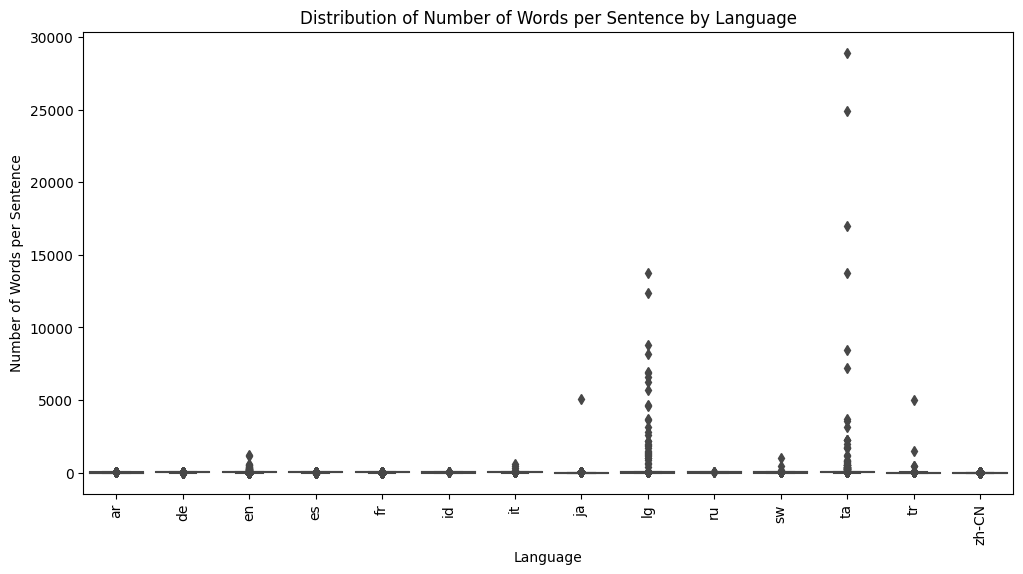

In [ ]:
# Create box plots for the distribution of words per sentence for each language
plt.figure(figsize=(12, 6))  # Set the figure size
sns.boxplot(x='language', y='num_words', data=df_filtered)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title("Distribution of Number of Words per Sentence by Language")
plt.xlabel("Language")
plt.ylabel("Number of Words per Sentence")
plt.show()

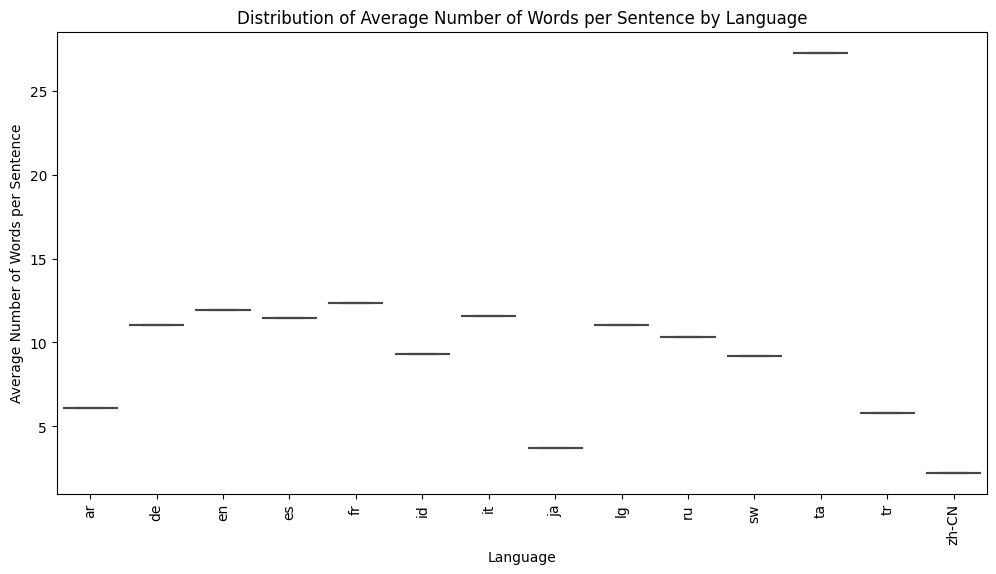

In [ ]:
# Create box plots for the distribution of average words per sentence by language
plt.figure(figsize=(12, 6))
sns.boxplot(x='language', y='num_words', data=avg_words_per_sentence)
plt.xticks(rotation=90)
plt.title("Distribution of Average Number of Words per Sentence by Language")
plt.xlabel("Language")
plt.ylabel("Average Number of Words per Sentence")
plt.show()

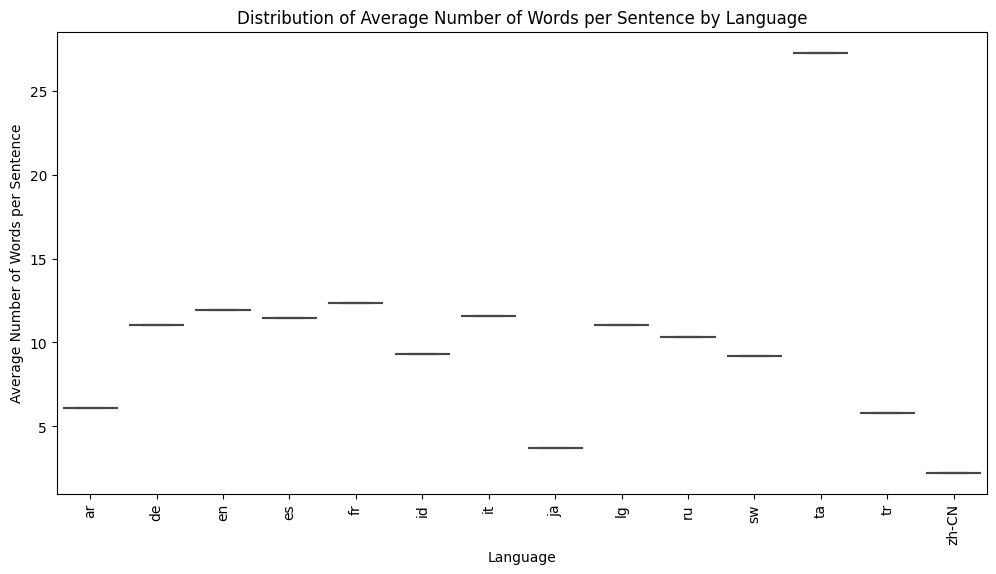

In [ ]:
# Calculate the average number of words per sentence by language
avg_words_per_sentence = df_filtered.groupby('language')['num_words'].mean().reset_index()

# Create box plots for the distribution of average words per sentence by language
plt.figure(figsize=(12, 6))
sns.boxplot(x='language', y='num_words', data=avg_words_per_sentence)
plt.xticks(rotation=90)
plt.title("Distribution of Average Number of Words per Sentence by Language")
plt.xlabel("Language")
plt.ylabel("Average Number of Words per Sentence")
plt.show()

11. For each language, find the 17 most frequent words after having removed stop words.

In [ ]:
# Specify the string you want to find
string_to_remove = '3447120ac93b7c7788687c259b7f55058804e4982c36174a9a0af762495a6c2310915d2b10562a1f75255d5b0a18eefb304ef7b042006d96d83158f22d238de8'

# Find the row index where the string appears in the 'sentence' column of the 'ja' language
row_index = df_all[(df_all['language'] == 'ja') & (df_all['sentence'].str.contains(string_to_remove))].index[0]

# Output the row index
print("Row Index:", row_index)
# Replace the specific string with an empty string in the 'sentence' column for a specific row
df_all.at[row_index, 'sentence'] = df_all.at[row_index, 'sentence'].replace(string_to_remove, '')

In [ ]:
def remove_punctuation(text):
    punctuation = r'''!()-[]{};:'"\,<>./?@#$%^&*_~...„“؟？！«»—–…“”；'’'''
    text = text.lower()
    text = ''.join([char for char in text if char not in punctuation])
    return text

In [ ]:
# Version 1
def most_frequent_words(language, num_words=17):
    try:
        stop_words = get_stop_words(language)
    except:
        stop_words = safe_get_stop_words(language)

    # Filter sentences for the specified language
    sentences = df_all[(df_all['language'] == language) & df_all['sentence'].notna()]['sentence']

    # Preprocess sentences to remove newline characters and punctuation
    sentences = sentences.str.replace('\n', ' ')
    sentences = sentences.apply(lambda x: remove_punctuation(x))

    words = [word.lower() for sentence in sentences for word in tokenizer(sentence) if word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

In [ ]:
# Version 2 with .isalpha()
def most_frequent_words(language, num_words=17):
    try:
        stop_words = get_stop_words(language)
    except:
        stop_words = safe_get_stop_words(language)

    # Filter sentences for the specified language
    sentences = df_all[(df_all['language'] == language) & df_all['sentence'].notna()]['sentence']

    # Preprocess sentences to remove newline characters
    sentences = sentences.str.replace('\n', ' ')

    words = [word.lower() for sentence in sentences for word in tokenizer(sentence) if word.isalpha() and word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

In [ ]:
top_words_by_language = {language: most_frequent_words(language) for language in df_all['language'].unique()}
top_words_df = pd.DataFrame({language: top_words_by_language[language] for language in df_all['language'].unique()})

# Set column names for the 17 rows
top_words_df.index = [f"Word_{i + 1}" for i in range(17)]

# Modify the df to move the number of occurrences outside of parentheses
for language in df_all['language'].unique():
    top_words_df[language] = top_words_df[language].apply(lambda x: str(x).replace('(', '').replace(')', ''))

# Remove the comma separating the word and the number
top_words_df = top_words_df.applymap(lambda x: x.replace(', ', ' '))
top_words_df

,ar,id,it,ja,ru,tr,zh-CN,de,en,es,fr,lg,sw,ta
Word_1,'أن' 1990,'untuk' 630,'due' 5969,'ja' 584,'должны' 662,'o' 1015,'明朝政治人物' 147,'wurde' 37952,'also' 68784,'dos' 8556,'s' 25784,'mu' 24921,'ya' 26320,'என' 13141
Word_2,'سامي' 1744,'orang' 287,'stato' 4422,'common' 292,'слово' 611,'mi' 1012,'进士出身' 127,'wurden' 12650,'two' 30285,'encuentra' 5921,'plus' 21926,'ku' 15452,'na' 24823,'கள' 12144
Word_3,'إلى' 1148,'tom' 240,'dopo' 4171,'voice' 292,'является' 606,'var' 951,'民籍' 63,'zwei' 10037,'one' 29646,'parte' 5114,'c' 18874,'n' 12338,'wa' 17516,'த' 11463
Word_4,'هل' 1092,'menjadi' 226,'parte' 3825,'twenties' 261,'безопасности' 531,'şey' 921,'军籍' 32,'heute' 8923,'first' 23253,'ser' 4995,'également' 14116,'lg' 11706,'kwa' 9615,'ta' 8052
Word_5,'أنا' 829,'memiliki' 221,'viene' 3607,'male' 261,'наций' 482,'mı' 920,'汉族' 26,'jedoch' 8902,'can' 18797,'ciudad' 4853,'trois' 8026,'nga' 10637,'ni' 8183,'க' 6871
Word_6,'توم' 717,'satu' 211,'anni' 3304,'しかし' 86,'объединенных' 466,'kadar' 901,'中国共产党党员' 24,'gibt' 7718,'school' 18409,'además' 4545,'après' 7723,'nti' 6223,'katika' 6152,'பட' 4478
Word_7,'الله' 708,'dua' 198,'essere' 3269,'彼は' 64,'организации' 460,'değil' 851,'清朝政治人物' 24,'zeit' 7523,'new' 18406,'tres' 4468,'plusieurs' 7516,'common' 5853,'za' 5313,'voice' 4027
Word_8,'يا' 654,'kota' 182,'prima' 2871,'また' 53,'поэтому' 434,'sonra' 753,'万历十四年' 19,'später' 7286,'many' 17926,'años' 4355,'saint' 7224,'voice' 5853,'la' 4934,'common' 4026
Word_9,'إن' 613,'hari' 177,'inoltre' 2860,'これは' 47,'имеет' 428,'tr' 742,'万历八年' 17,'liegt' 6795,'later' 17102,'actualmente' 4253,'ville' 6822,'ne' 5489,'moja' 2902,'அவர' 3908
Word_10,'ليلى' 589,'anak' 167,'venne' 2714,'その後' 45,'конференции' 400,'yok' 636,'隆庆二年' 15,'drei' 6757,'used' 16819,'nombre' 4032,'partie' 6713,'abantu' 5199,'kuwa' 2807,'இந' 3527


12. Compute, for each language, the size of the available data both in term of duration and in terms of number of words.

In [ ]:
tokenizer = MosesTokenizer()

In [ ]:
# Preprocess sentences to ensure they are strings and remove newline characters
df_all['sentence'] = df_all['sentence'].astype(str).str.replace('\n', ' ')

# Tokenize sentences using the Moses tokenizer and calculate word count for each row
df_all['tokens'] = df_all['sentence'].apply(lambda x: tokenizer(x))
df_all['num_words'] = df_all['tokens'].apply(len)

# Group the data by language and calculate the total duration and total word count for each language
language_data = df_all.groupby('language').agg({'duration[ms]': 'sum', 'num_words': 'sum'})

# Rename the columns for clarity
language_data = language_data.rename(columns={'duration[ms]': 'Total duration', 'num_words': 'Total nb words'})

# Reset the index to make 'language' a column
language_data = language_data.reset_index()
language_data

,language,Total duration,Total nb words
0,ar,162160035,237850
1,de,3341755685,6458449
2,en,6174878911,12990989
3,es,1720018728,3754499
4,fr,2820768179,6716013
5,id,42566295,80035
6,it,975913433,2105551
7,ja,57698436,44000
8,lg,466082146,865269
9,ru,192763014,376533


## 2 Measuring the similarity between American presidents speeches

13. Reproduce the plot of Figure 1.

In [ ]:
#!tar -xvf "/content/drive/MyDrive/Data analysis/data/US_Inaugural_Addresses.tar.bz2" -C "/content/drive/MyDrive/Data analysis/data"

In [ ]:
# Initialize an empty list to store the text data
texts = []
presidents = []
dates = []
years = []

# Iterate through the text files and append their content to the list
for file in Path("/content/drive/MyDrive/Data_analysis/data/US_Inaugural_Addresses").rglob("*.txt"):
    years.append(file.stem.split("_")[-1])
    with file.open(encoding='latin-1') as f:
        parts = f.read().strip().split("\t")
        if len(parts) == 3:
          president, date, text = parts
        else:
          content = parts[0].strip().split(" ")
          president = " ".join(content[:2])
          date = content[2]
          text = " ".join(content[3:])
        presidents.append(president)
        dates.append(date)
        texts.append(text)

speeches = pd.DataFrame({'president': presidents, 'year': years, 'date': dates, 'text': texts})
speeches = speeches.sort_values(by='year')
speeches

['Donald', 'Trump', '1/20/2017', 'Chief', 'Justice', 'Roberts,', 'President', 'Carter,', 'President', 'Clinton,', 'President', 'Bush,', 'President', 'Obama,', 'fellow', 'Americans,', 'and', 'people', 'of', 'the', 'world:', 'Thank', 'you.\nWe,', 'the', 'citizens', 'of', 'America,', 'are', 'now', 'joined', 'in', 'a', 'great', 'national', 'effort', 'to', 'rebuild', 'our', 'country', 'and', 'restore', 'its', 'promise', 'for', 'all', 'of', 'our', 'people.', 'Together,', 'we', 'will', 'determine', 'the', 'course', 'of', 'America', 'and', 'the', 'world', 'for', 'many,', 'many', 'years', 'to', 'come.', 'We', 'will', 'face', 'challenges,', 'we', 'will', 'confront', 'hardships,', 'but', 'we', 'will', 'get', 'the', 'job', 'done.', 'Every', '4', 'years,', 'we', 'gather', 'on', 'these', 'steps', 'to', 'carry', 'out', 'the', 'orderly', 'and', 'peaceful', 'transfer', 'of', 'power,', 'and', 'we', 'are', 'grateful', 'to', 'President', 'Obama', 'and', 'First', 'Lady', 'Michelle', 'Obama', 'for', 'their'

,president,year,date,text
6,George Washington,1789,1789-04-30,Fellow-Citizens of the Senate and of the House...
13,George Washington,1793,1793-03-04,Fellow Citizens I AM again called upon by the ...
50,John Adams,1797,1797-03-04,"WHEN it was first perceived, in early times, t..."
41,Thomas Jefferson,1801,1801-03-04,Friends and Fellow-Citizens CALLED upon to und...
56,Thomas Jefferson,1805,1805-03-04,"PROCEEDING, fellow-citizens, to that qualifica..."
42,James Madison,1809,1809-03-04,Unwilling to depart from examples of the most ...
31,James Madison,1813,1813-03-04,About to add the solemnity of an oath to the o...
17,James Monroe,1817,1817-03-04,I should be destitute of feeling if I was not ...
5,James Monroe,1821,1821-03-04,Fellow-Citizens I shall not attempt to describ...
40,John Quincy Adams,1825,1825-03-04,In compliance with an usage coeval with the ex...


In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(speeches['text'])

# Create a DataFrame with TF-IDF vectors
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the president names to the TF-IDF DataFrame
president_tfidf_df = pd.concat([speeches['president'], tfidf_df], axis=1)
president_tfidf_df

,president,000,100,120,125,13,14th,151,15th,16,...,yorktown,young,younger,youngest,youth,youthful,zeal,zealous,zealously,zone
6,George Washington,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,George Washington,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011271,0.000000
50,John Adams,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.075630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41,Thomas Jefferson,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
56,Thomas Jefferson,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.021825,0.000000,0.000000,0.033725,0.000000,0.000000,0.000000,0.000000,0.000000
42,James Madison,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31,James Madison,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,James Monroe,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,James Monroe,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048748,0.000000
40,John Quincy Adams,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.031211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Extract the TF-IDF vectors and president names
tfidf_vectors = tfidf_df.to_numpy()
president_names = speeches['president'].tolist()

# Calculate cosine similarity between all pairs of speeches
cosine_similarities = cosine_similarity(tfidf_vectors)

# Create a DataFrame to store the cosine similarities
cosine_similarity_df = pd.DataFrame(cosine_similarities, columns=president_names, index=president_names)

# Calculate and store similarities for all pairs of presidents
similarities = []

for president1 in presidents:
    row = []
    for president2 in presidents:
        similarity = cosine_similarity_df.loc[president1, president2]
        row.append(similarity)
    similarities.append(row)

# Create a DataFrame to store all the similarities
all_similarities_df = pd.DataFrame(similarities, columns=presidents, index=presidents)
all_similarities_df

,Zachary Taylor,William Howard Taft,William McKinley,Ulysses S. Grant,Jimmy Carter,James Monroe,George Washington,Franklin D. Roosevelt,Barack Obama,Franklin D. Roosevelt,...,Ulysses S. Grant,Donald Trump,John Adams,John F. Kennedy,Rutherford B. Hayes,Woodrow Wilson,Ronald Reagan,Grover Cleveland,Thomas Jefferson,Andrew Jackson
Zachary Taylor,1.0,0.19594,William McKinley 0.267081 William McKinley ...,Ulysses S. Grant 0.170185 Ulysses S. Grant ...,0.10004,James Monroe 0.259635 James Monroe 0.213...,George Washington 0.183836 George Washingto...,Franklin D. Roosevelt 0.138396 Franklin D. ...,Barack Obama 0.111232 Barack Obama 0.098...,Franklin D. Roosevelt 0.138396 Franklin D. ...,...,Ulysses S. Grant 0.170185 Ulysses S. Grant ...,0.096939,0.213882,0.098666,0.243674,Woodrow Wilson 0.102114 Woodrow Wilson 0...,Ronald Reagan 0.117745 Ronald Reagan 0.1...,Grover Cleveland 0.241885 Grover Cleveland ...,Thomas Jefferson 0.179783 Thomas Jefferson ...,Andrew Jackson 0.260532 Andrew Jackson 0...
William Howard Taft,0.19594,1.0,William McKinley 0.357698 William McKinley ...,Ulysses S. Grant 0.184493 Ulysses S. Grant ...,0.10086,James Monroe 0.238394 James Monroe 0.248...,George Washington 0.148593 George Washingto...,Franklin D. Roosevelt 0.172719 Franklin D. ...,Barack Obama 0.125780 Barack Obama 0.131...,Franklin D. Roosevelt 0.172719 Franklin D. ...,...,Ulysses S. Grant 0.184493 Ulysses S. Grant ...,0.106505,0.181524,0.10767,0.26154,Woodrow Wilson 0.163480 Woodrow Wilson 0...,Ronald Reagan 0.150511 Ronald Reagan 0.1...,Grover Cleveland 0.212758 Grover Cleveland ...,Thomas Jefferson 0.154164 Thomas Jefferson ...,Andrew Jackson 0.164505 Andrew Jackson 0...
William McKinley,William McKinley 0.267081 William McKinley ...,William McKinley 0.357698 William McKinley ...,William McKinley William Mc...,Ulysses S. Grant Ulysses S....,William McKinley 0.124830 William McKinley ...,James Monroe James Monroe W...,George Washington George Wa...,Franklin D. Roosevelt Frank...,Barack Obama Barack Obama W...,Franklin D. Roosevelt Frank...,...,Ulysses S. Grant Ulysses S....,William McKinley 0.149731 William McKinley ...,William McKinley 0.263894 William McKinley ...,William McKinley 0.111312 William McKinley ...,William McKinley 0.327265 William McKinley ...,Woodrow Wilson Woodrow Wils...,Ronald Reagan Ronald Reagan...,Grover Cleveland Grover Cle...,Thomas Jefferson Thomas Jef...,Andrew Jackson Andrew Jacks...
Ulysses S. Grant,Ulysses S. Grant 0.170185 Ulysses S. Grant ...,Ulysses S. Grant 0.184493 Ulysses S. Grant ...,William McKinley William Mc...,Ulysses S. Grant Ulysses S....,Ulysses S. Grant 0.094022 Ulysses S. Grant ...,James Monroe James Monroe U...,George Washington George Wa...,Franklin D. Roosevelt Frank...,Barack Obama Barack Obama U...,Franklin D. Roosevelt Frank...,...,Ulysses S. Grant Ulysses S....,Ulysses S. Grant 0.089078 Ulysses S. Grant ...,Ulysses S. Grant 0.164506 Ulysses S. Grant ...,Ulysses S. Grant 0.093891 Ulysses S. Grant ...,Ulysses S. Grant 0.217257 Ulysses S. Grant ...,Woodrow Wilson Woodrow Wils...,Ronald Reagan Ronald Reagan...,Grover Cleveland Grover Cle...,Thomas Jefferson Thomas Jef...,Andrew Jackson Andrew Jacks...
Jimmy Carter,0.10004,0.10086,William McKinley 0.124830 William McKinley ...,Ulysses S. Grant 0.094022 Ulysses S. Grant ...,1.0,James Monroe 0.128485 James Monroe 0.118...,George Washington 0.076456 George Washingto...,Franklin D. Roosevelt 0.109078 Franklin D. ...,Barack Obama 0.195018 Barack Obama 0.201...,Franklin D. Roosevelt 0.109078 Franklin D. ...,...,Ulysses S. Grant 0.094022 Ulysses S. Grant ...,0.161464,0.12916,0.179315,0.121625,Woodrow Wilson 0.149831 Woodrow Wilson 0...,Ronald Reagan 0.206959 Ronald Reagan 0.2...,Grover Cleveland 0.118245 Grover Cleveland ...,Thomas Jefferson 0.113779 Thomas Jefferson ...,Andrew Jackson 0.072807 Andrew Jackson 0...
James Monroe,James Monroe 0.259635 James Monroe 0.213...,James Monroe 0.238394 James Monroe 0.248...,William McKinley William McKinl...,Ulysses S. Gran

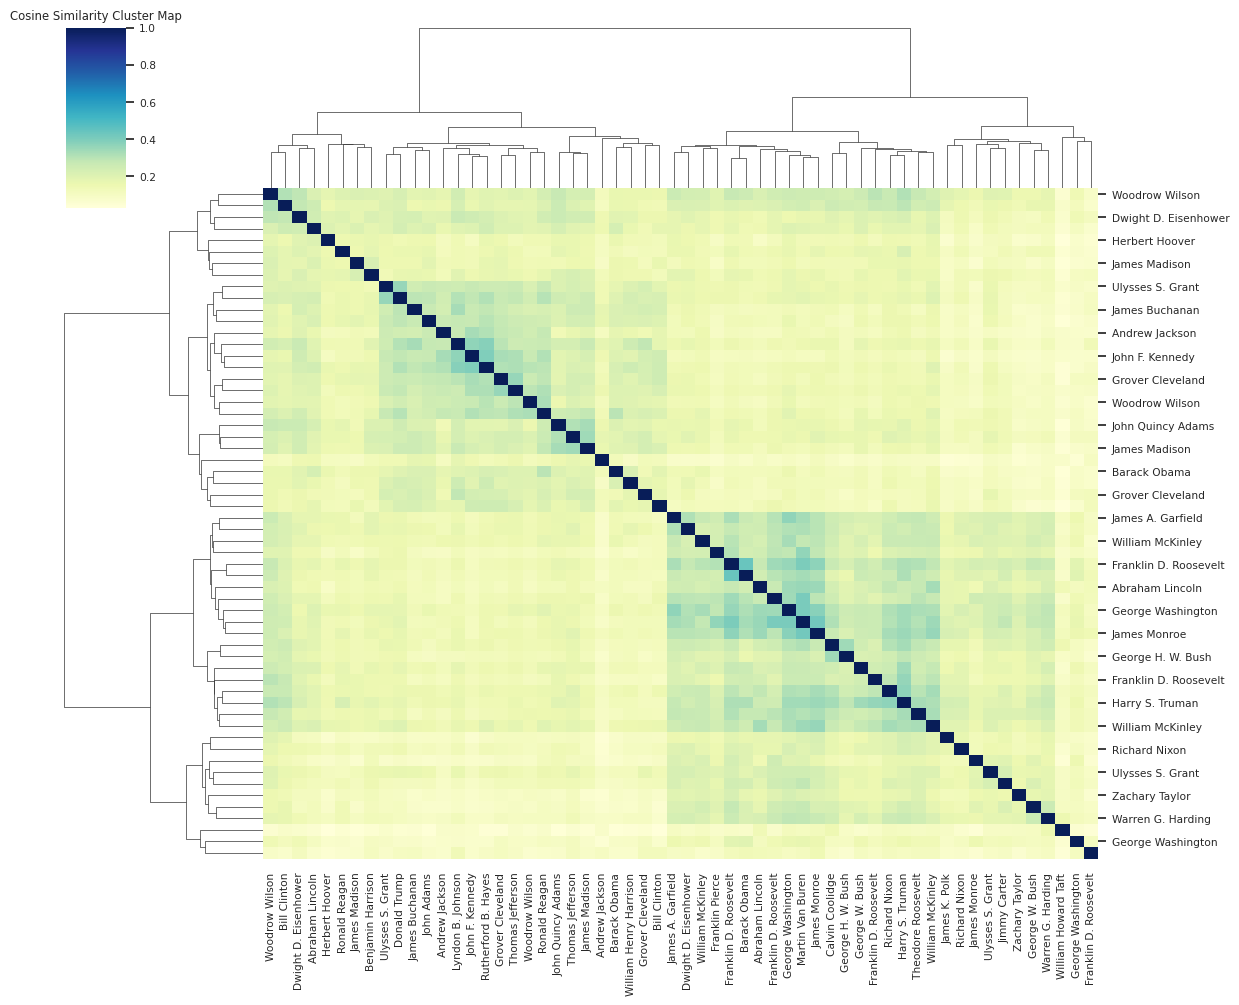

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(speeches['text'])
# Calculate cosine similarity between all pairs of speeches
cosine_similarities = cosine_similarity(tfidf_matrix)
# Create a DataFrame to store the cosine similarities
cosine_similarity_df = pd.DataFrame(cosine_similarities, columns=presidents, index=presidents)

sns.set(font_scale=0.7)
sns.clustermap(cosine_similarity_df, cmap="YlGnBu", method="ward", figsize=(12, 10))
plt.title('Cosine Similarity Cluster Map')
plt.show()

14. Reproduce the plot of Figure 1 considering only the 10 last US president.

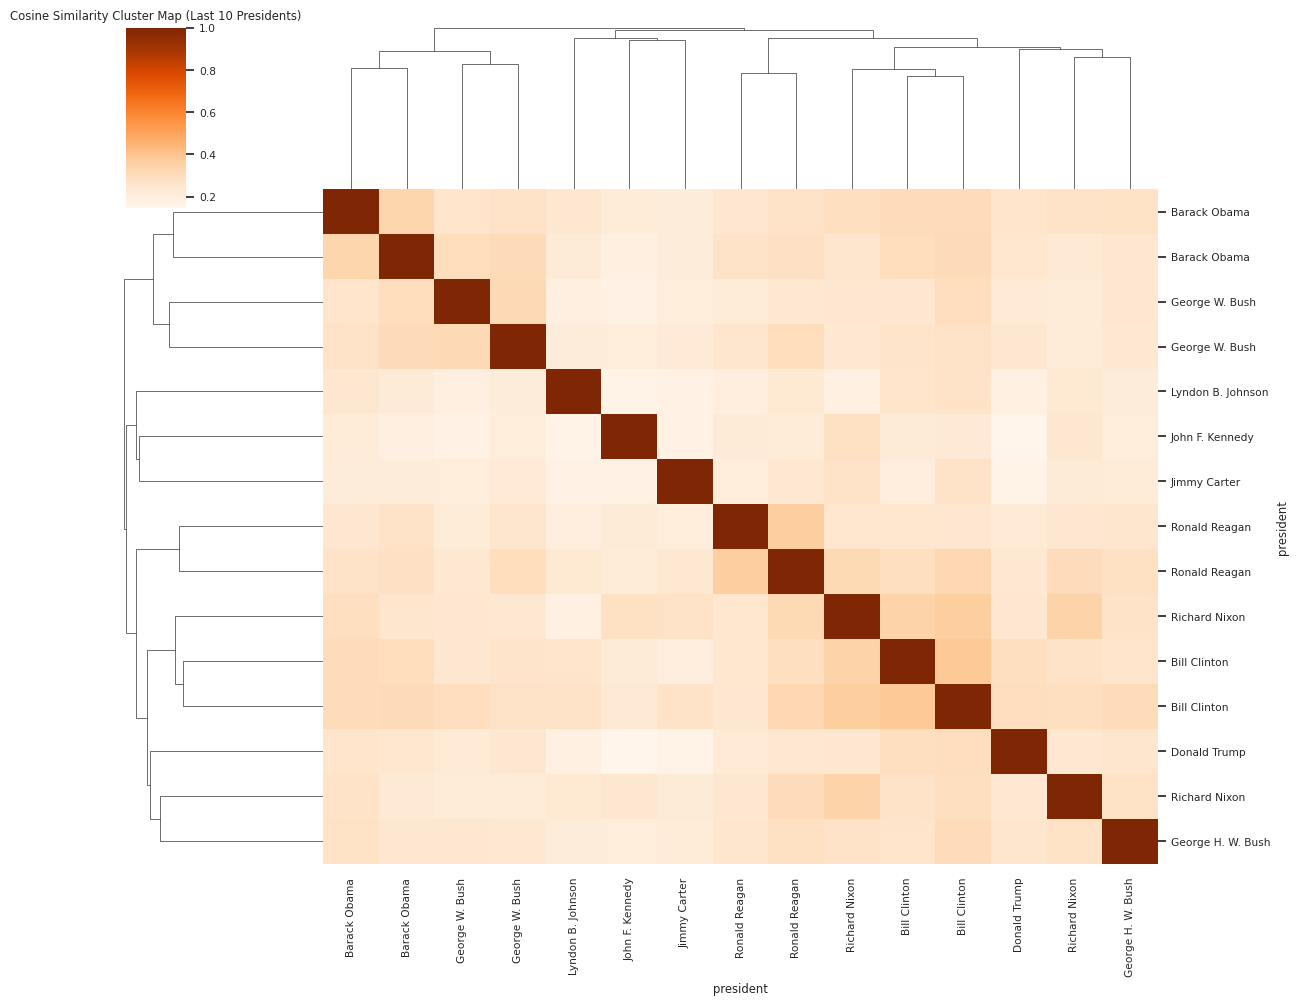

In [ ]:
# Filter the DataFrame to include only the last 10 presidents

last_10_presidents = speeches['president'].unique()[-10:]
filtered_speeches = speeches[speeches['president'].isin(last_10_presidents)]
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_speeches['text'])
cosine_similarities = cosine_similarity(tfidf_matrix)
cosine_similarity_df = pd.DataFrame(cosine_similarities,
                                    columns=filtered_speeches['president'],
                                    index=filtered_speeches['president'])

# Use seaborn's clustermap to create a clustered heatmap
sns.set(font_scale=0.7)
sns.clustermap(cosine_similarity_df, cmap="Oranges", method="ward", figsize=(12, 10))
plt.title('Cosine Similarity Cluster Map (Last 10 Presidents)')
plt.show()